In [1]:

#!pip install --upgrade --quiet numpy scipy noisyopt matplotlib qiskit
#!pip install --upgrade --force-reinstall --quiet qiskit qiskit-aer

In [2]:
import qiskit
import qiskit_aer
print("Qiskit:", qiskit.__version__)
print("Qiskit Aer:", qiskit_aer.__version__)
try:
    from qiskit_aer.primitives import Estimator
    print("qiskit_aer.primitives.Estimator is available!")
except ImportError:
    print("No qiskit_aer.primitives.Estimator!")


Qiskit: 2.1.1
Qiskit Aer: 0.17.1
qiskit_aer.primitives.Estimator is available!


/tmp/ipython-input-1-3592921249.py:147: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  una_ans = RealAmplitudes(num_qubits=nqb, entanglement='linear', reps=lay)


Layers : 2
Number of parameters:  12
Number of DOFs:  16
   *** Beginning optimization ***   
Iteration : 1, Current cost: -0.009532912700187192
Iteration : 2, Current cost: -0.010530330801732574
Iteration : 3, Current cost: -0.014471924357399604
Iteration : 4, Current cost: -0.015841392926921768
Iteration : 5, Current cost: -0.01705854085013103
Iteration : 6, Current cost: -0.014810945137531228
Iteration : 7, Current cost: -0.015153080140643631
Iteration : 8, Current cost: -0.014755408062491026
Iteration : 9, Current cost: -0.01643047853768741
Iteration : 10, Current cost: -0.016719176763924697
Iteration : 11, Current cost: -0.014546990643331365
Iteration : 12, Current cost: -0.013888846807595008
Iteration : 13, Current cost: -0.016313807396195323
Message : convergence within deltatol. dim 7 is free at optimum. dim 1 is free at optimum. dim 10 is free at optimum. dim 6 is free at optimum. dim 0 is free at optimum. dim 5 is free at optimum. dim 9 is free at optimum. dim 4 is free at op

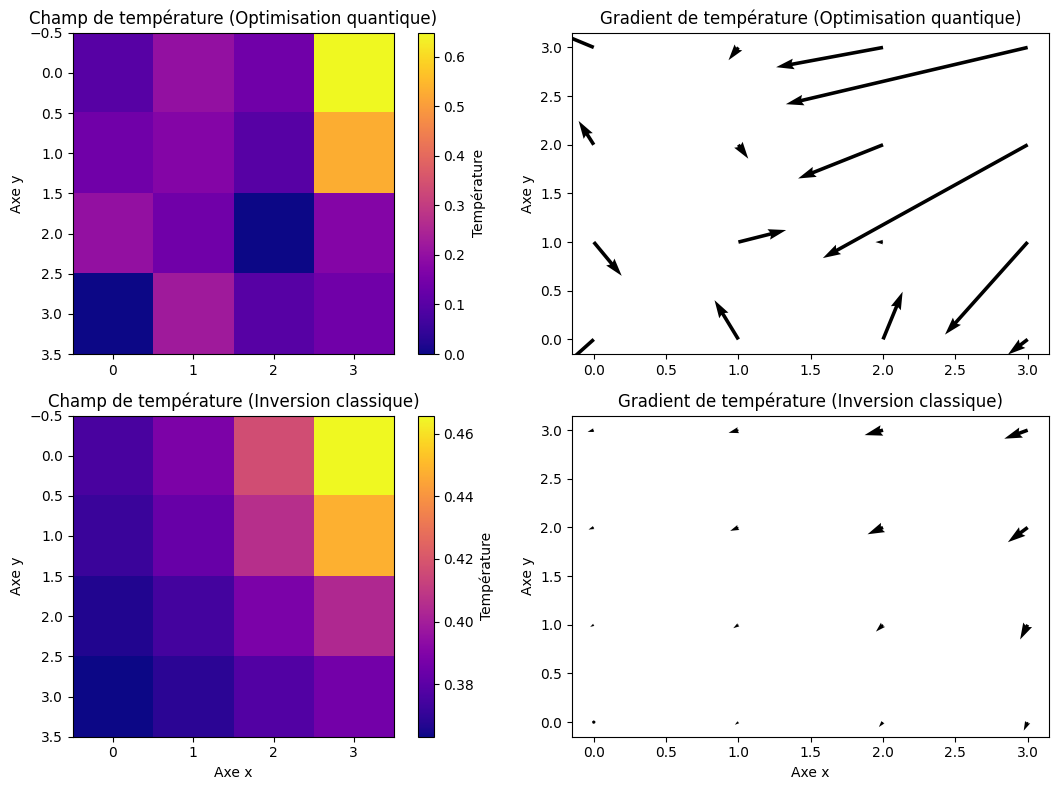

In [1]:
import numpy as np
import math as m
import time
import scipy as sp
import noisyopt as no
import qiskit as qi
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.primitives import Estimator, Sampler
import matplotlib.pyplot as plt

# NOISY BACKEND
# 100 just an example
shots = 100
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['rx', 'ry', 'rz'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 2), ['cx'])

backend = AerSimulator(noise_model=noise_model)
# Use backend.run(qc, shots=shots) in the sampling functions

## STIFFNESS MATRIX
def get_K(Nx, Ny, dx, dy, alpha):
    N = Nx * Ny
    K = sp.sparse.lil_matrix((N, N))
    for i in range(Nx):
        for j in range(Ny):
            idx = i * Ny + j
            if i < Nx-1:
                right = idx + Ny
                K[idx, idx] += alpha / dx**2
                K[idx, right] -= alpha / dx**2
                K[right, idx] -= alpha / dx**2
                K[right, right] += alpha / dx**2
            if j < Ny-1:
                top = idx + 1
                K[idx, idx] += alpha / dy**2
                K[idx, top] -= alpha / dy**2
                K[top, idx] -= alpha / dy**2
                K[top, top] += alpha / dy**2
    return K

def flux(nx, ny, prc, flux_bc):
    nqb = nx + ny
    f = np.zeros(2 ** nqb)
    Nx = 2 ** nx
    Ny = 2 ** ny
    miny = round((1-prc) * Ny)
    for i in range(miny, Ny):
        f[(Nx - 1) * Ny + i] = flux_bc
    f /= np.linalg.norm(f)
    return f

def cost_cl(x, H, f):
    cost = -1 / 2 * (f @ x) ** 2 / (x.T @ H @ x)
    return cost

def cost_func(par, SPOH, f, una_ans):
    cost = -1/2 * fpsi(f, una_ans, par)**2 / psiHpsi(SPOH, una_ans, par)
    return cost

def psiHpsi(SPOH, una_ans, par):

    # Prepare the circuit
    cir = una_ans.assign_parameters(parameters=par, inplace=False).decompose()
    qc = qi.QuantumCircuit(nqb)
    qc.compose(cir, inplace=True)
    qc.measure_all()
    # Run
    job = backend.run(qc, shots=shots)
    counts = job.result().get_counts()
    # Convert counts to probabilities
    probs = np.zeros(2 ** nqb)
    for idx, bit in enumerate([format(i, f'0{nqb}b') for i in range(2 ** nqb)]):
        probs[idx] = counts.get(bit, 0) / shots

    Hmat = SPOH.to_matrix().real
    expval = 0.0
    for i in range(2 ** nqb):
        expval += probs[i] * Hmat[i, i]
    return expval


def fpsi(f, una_ans, par):
    psi = sampleGate(una_ans.assign_parameters(parameters=par, inplace=False))
    fpsi_ = f @ psi
    return fpsi_

def sampleGate(gate):
    qc = qi.QuantumCircuit(nqb)
    # Decompose the ansatz so Aer doesn't see a custom instruction
    qc.compose(gate.decompose(), inplace=True)
    qc.measure_all()
    job = backend.run(qc, shots=shots)
    counts = job.result().get_counts()
    state = np.zeros(2 ** nqb)
    for idx, bit in enumerate([format(i, f'0{nqb}b') for i in range(2 ** nqb)]):
        state[idx] = np.sqrt(counts.get(bit, 0) / shots)
    return state

def norm_q(par, H, f, una_ans):
    # Only works in the noiseless case (see note in psiHpsi)
    raise NotImplementedError("norm_q for noisy backend requires expectation value computation.")

def build_callback(SPOH, f, callback_dict, una_ans):
    def callback(current_vector):
        callback_dict["iters"] += 1
        callback_dict["prev_vector"] = current_vector
        try:
            current_cost = cost_func(current_vector.real, SPOH, f, una_ans)
        except NotImplementedError:
            current_cost = np.nan
        callback_dict["cost_history"].append(current_cost)
        print(f"Iteration : {callback_dict['iters']}, Current cost: {current_cost}")
    return callback

## QUANTUM PARAMETERS
nx = 2
ny = 2
nqb = nx + ny
lay = 2

## SPACE PARAMETERS
L = 1.0
Nx = 2 ** nx
Ny = 2 ** ny
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
dx = L / (Nx-1.)
dy = L / (Ny-1.)

alpha = 1.0
Ksp = get_K(Nx, Ny, dx, dy, alpha)
pen = 0.1*9/4
Ksp += pen * np.eye(Nx*Ny)
K = Ksp.toarray()
SPOH = SparsePauliOp.from_operator(Operator(K))

therm_bc = 0
flux_bc = 3/np.sqrt(2)/4/dx
prc = 0.5
f = flux(nx, ny, prc, flux_bc)

una_ans = RealAmplitudes(num_qubits=nqb, entanglement='linear', reps=lay)
#una_ans = li.RealAmplitudes(num_qubits=nqb, entanglement='sca', reps=lay)

callback_dict = {"prev_vector": None, "iters": 0, "cost_history": []}
callback = build_callback(SPOH, f, callback_dict, una_ans)

num_par = una_ans.num_parameters
BC = [[-2*np.pi, 2*np.pi] for _ in range(num_par)]

par_warm = np.array(2 * np.pi * np.random.random(num_par))

## OPTIMIZATION
optim = True
if optim:
    print("Layers :", lay)
    print("Number of parameters: ", num_par)
    print("Number of DOFs: ", 2**nqb)
    print("   *** Beginning optimization ***   ")
    start = time.perf_counter()
    res = no.minimizeCompass(
        cost_func, par_warm,
        args=(SPOH, f, una_ans),
        bounds=BC, scaling=None,
        redfactor=2.0, deltainit=1.0, deltatol=1e-3,
        feps=1e-3, errorcontrol=True, funcNinit=40, funcmultfactor=1.0,
        paired=False, alpha=0.1, disp=False, callback=callback
    )
    end = time.perf_counter()
    exe_time = end - start

    par_ini = np.array(2 * np.pi * np.random.random(2 ** nqb))
    resCL = sp.optimize.minimize(cost_cl, par_ini, args=(K, f), tol=1e-5, method='L-BFGS-B')

    print("Message :", res.message)
    print("Success :", res.success)
    print("nfev :", res.nfev)
    print("x :", res.x)
    print(f"Optimization time: {exe_time//60:.0f}m {exe_time%60:.2f}s")
    print("Quantum minimum :", res.fun)
    print("Classical minimum :", resCL.fun.real)

    res = res.x

else:
    pass

def get_Xq(res_x, una_ans):
    ans_sol = una_ans.assign_parameters(parameters=res_x, inplace=False)
    qc = qi.QuantumCircuit(nqb)
    qc.compose(ans_sol.decompose(), inplace=True)
    qc.measure_all()
    job = backend.run(qc, shots=shots)
    counts = job.result().get_counts()
    Xquant = np.zeros(2 ** nqb)
    for idx, bit in enumerate([format(i, f'0{nqb}b') for i in range(2 ** nqb)]):
        Xquant[idx] = np.sqrt(counts.get(bit, 0) / shots)
    return Xquant

xquant = get_Xq(res, una_ans)
ucl = sp.sparse.linalg.spsolve(Ksp.tocsr(), f).real
print("Classical minimum with linalg:", cost_cl(ucl, K, f).real)
par_ini =  np.random.random(2 ** nqb)/100
resCL = sp.optimize.minimize(cost_cl, par_ini, args=(K, f), tol=1e-7, method='L-BFGS-B')
print("Classical minimum with BFGS:", resCL.fun.real)

normq = np.linalg.norm(xquant)
normc = np.linalg.norm(ucl)
print("Norme classique Xquant :", normq)
print("Norme classique Ucl :", normc)

# norm_ropt = norm_q(res, K, f, una_ans) # Disabled for noisy
# print("Norme quantique Xquant :", norm_ropt, "\n")
# xquant = np.multiply(xquant, norm_ropt)

def MSE(u, v):
    return sum((u - v) ** 2) / len(u)
mse = MSE(xquant, ucl)
print(f"MSE error : {mse:.6f}")

u = xquant.reshape((Nx, Ny)).T
ucl = ucl.reshape((Nx, Ny)).T[::-1]

vmin = min(u.min(), ucl.min())
vmax = max(u.max(), ucl.max())

fig, ax = plt.subplots(2, 2, figsize=(11, 8))
iso = False

if iso:
    cax_heat = ax[0][0].contourf(x, y, u[::, ::], levels=20, cmap='plasma')
else:
    cax_heat = ax[0][0].imshow(u[::-1, ::], cmap='plasma', interpolation='nearest')
ax[0][0].set_title(label='Champ de température (Optimisation quantique)')
ax[0][0].set_ylabel("Axe y")
fig.colorbar(cax_heat, ax=ax[0][0], label='Température')

grad_x, grad_y = np.gradient(np.multiply(u[::, ::], -1))
ax[0][1].quiver(grad_y, grad_x, scale=1)
ax[0][1].set_title('Gradient de température (Optimisation quantique)')
ax[0][1].set_ylabel("Axe y")

if iso:
    cax_heat = ax[1][0].contourf(x, y, ucl[::-1, ::], levels=20, cmap='plasma')
else:
    cax_heat = ax[1][0].imshow(ucl[::, ::], cmap='plasma', interpolation='nearest')
ax[1][0].set_title(label='Champ de température (Inversion classique)')
ax[1][0].set_xlabel("Axe x")
ax[1][0].set_ylabel("Axe y")
fig.colorbar(cax_heat, ax=ax[1][0], label='Température')

grad_x, grad_y = np.gradient(np.multiply(ucl[::-1], -1))
ax[1][1].quiver(grad_y, grad_x, scale=1)
ax[1][1].set_title('Gradient de température (Inversion classique)')
ax[1][1].set_xlabel("Axe x")
ax[1][1].set_ylabel("Axe y")

plt.tight_layout()
plt.show()

